# The Solow Model

Imports and set magics:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sympy as sp
from IPython.display import display, Markdown

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# Basic Solow Model

**Write out the model in equations here.** 

Make sure you explain well the purpose of the model and comment so that other students who may not have seen it before can follow.  

The Basic Solow model has the following equations:
1. **Production Function**:
   $Y_t = K_t^\alpha L_t^{1-\alpha}$ \
   Where:
   - $Y_t$ is the output at time $t$.
   - $K_t$ is the capital stock at time $t$.
   - $L_t$ is the labor force at time $t$.
   - $\alpha$ is the output elasticity of capital, $0 < \alpha < 1$.

2. **Capital Accumulation**:
   $K_{t+1} = sY_t + (1 - \delta)K_t$ \
   Where:
   - $s$ is the savings rate, which determines the portion of output invested back into capital.
   - $\delta$ is the depreciation rate of capital.

3. **Population Growth**:
   $L_{t+1} = (1 + n)L_t$ \
   Where:
   - $n$ is the population’s growth rate.


## Analytical solution

To solve the model, we will find the steady state of capital in per capita terms, i.e.: \
$k^* = (\frac{s}{n+\delta})^\frac{1}{1-\alpha}$

The code provided is a structured approach to analytically solving for the steady state of capital per capita in the Solow economic growth model using Python’s sympy library. Here’s a concise overview of the steps and methodology:

Symbol Definition: The script starts by defining necessary symbols for key model parameters—capital elasticity (alpha), savings rate (s), capital depreciation rate (delta), and labor growth rate (n). It also defines k for capital per capita.
Formulate the.

Production Function: It sets up the production function per capita, expressed as y = k**alpha, highlighting the relationship between output per capita and capital per capita.

Establish the Steady State Equation: The steady state condition is formulated by equating current capital per capita (k) to next period’s capital per capita. This is derived from reinvested savings and accounting for depreciation and labor growth, effectively setting the foundation for solving the equilibrium condition where the economy ceases to change.

Solve Analytically: Using SymPy’s solve function, the code analytically resolves the steady state equation to find an expression for k that makes the net change in capital per capita zero, identifying the level of capital per capita where the economy stabilizes.

In [2]:
# Define the symbols
alpha = sp.symbols('alpha')  # Capital's output elasticity
s = sp.symbols('s')  # Savings rate
delta = sp.symbols('delta')  # Depreciation rate
n = sp.symbols('n')  # Growth rate of labor
k = sp.symbols('k')  # Capital per capita

# Production function per capita
y = k**alpha  # Output per capita

# Capital accumulation per capita, rewritten to isolate k at steady state
# We assume steady state, so k_next = k
steady_state_eq = sp.Eq(k, s * y / (delta + n))

# Solve the steady state equation explicitly for k
steady_state_solution = sp.solve(steady_state_eq, k)

# Display the equation and solution in Markdown using LaTeX
display(Markdown('### Steady State Equation:'))
display(steady_state_eq)

display(Markdown('### Steady State Solution:'))
display(steady_state_solution[0])  # Assuming there's at least one solution



### Steady State Equation:

Eq(k, k**alpha*s/(delta + n))

### Steady State Solution:

(s/(delta + n))**(-1/(alpha - 1))

Turning the symbolic math steady state expressions into python functions using lambdify



In [9]:
# Create a function from the symbolic expression for practical use
k_star_func = sp.lambdify((alpha, s, delta, n), steady_state_solution[0], 'numpy')

# Assuming we have a model object with attribute values for parameters
class Model:
    def __init__(self):
        self.val = {
            'alpha': 0.33,
            's': 0.20,
            'delta': 0.05,
            'n': 0.01
        }

# Instantiate the model and get values
model = Model()

# Calculate k_star using the function and the values from the model
k_star_value = k_star_func(model.val['alpha'], model.val['s'], model.val['delta'], model.val['n'])
print("Steady state capital per capita (k^*):", format(k_star_value, ".10f"))


Steady state capital per capita (k^*): 6.0313709200


## Numerical solution

**Basic solow model**


In this section, we will delve into the process of obtaining the numerical solution for the Solow model. By numerically solving the Solow model, we can gain a deeper understanding of how these factors interact and influence economic growth over time. We will commence by formulating the differential equations that describe the dynamics of capital and production and plot these. 

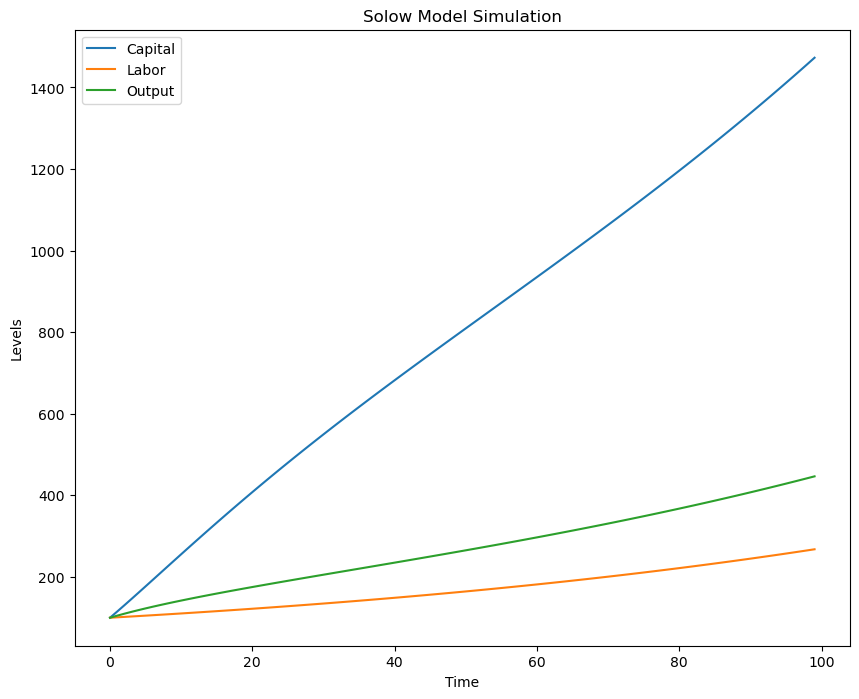

In [7]:
# Parameters
s = 0.2       # Savings rate
alpha = 0.3   # Output elasticity of capital
delta = 0.05  # Depreciation rate
n = 0.01      # Population growth rate
K0 = 100      # Initial capital stock
L0 = 100      # Initial labor
T = 100       # Number of time periods to simulate

# Initialize arrays to store the time series of capital, labor, and output
K = np.zeros(T)
L = np.zeros(T)
Y_base = np.zeros(T)
K[0] = K0
L[0] = L0

# Simulation
for t in range(T-1):
    Y_base[t] = K[t]**alpha * L[t]**(1-alpha)  # Production function
    K[t+1] = s * Y_base[t] + (1 - delta) * K[t]  # Capital accumulation
    L[t+1] = (1 + n) * L[t]  # Population growth

# Output in the last period
Y_base[T-1] = K[T-1]**alpha * L[T-1]**(1-alpha)

# Plotting the results
plt.figure(figsize=(10, 8))
plt.plot(K, label='Capital')
plt.plot(L, label='Labor')
plt.plot(Y_base, label='Output')
plt.title('Solow Model Simulation')
plt.xlabel('Time')
plt.ylabel('Levels')
plt.legend()
plt.show()


 In the basic Solow model, economic growth is primarily driven by increases in capital accumulation, with diminishing returns leading to a convergence towards a steady state

**Solow Model with technological growth**

We extend the model by implementing technological growth. We set the technological growth rate to 2% and visualize how this change affects output in the model compared to the base model.

The Extended Solow model has the following changes to the equation:
1. **Production Function**:
   $Y_t = K_t^\alpha L_t^{1-\alpha}$ \
   Where:
   - $Y_t$ is the output at time $t$.
   - $A_t$ is the technology level at time $t$.
   - $K_t$ is the capital stock at time $t$.
   - $L_t$ is the labor force at time $t$.
   - $\alpha$ is the output elasticity of capital, $0 < \alpha < 1$.

2. **Technology Growth**:
   $A_{t+1} = (1 + g)A_t$ \
   Where:
   - $g$ is the growth rate of technology.


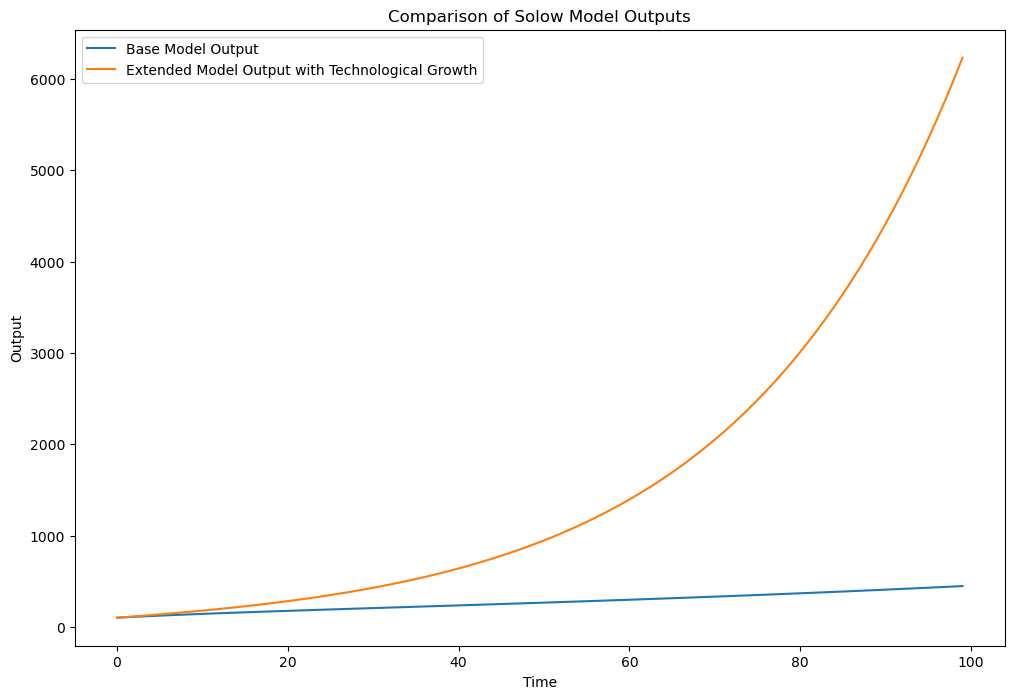

In [9]:
# Parameters for the extended model
g = 0.02       # Technological growth rate
A0 = 1         # Initial technology level

# Initialize arrays to store the time series
A = np.zeros(T)
Y_ext=np.zeros(T)
A[0] = A0

# Simulation with technology
for t in range(T-1):
    Y_ext[t] = A[t] * K[t]**alpha * L[t]**(1-alpha)  # Production function with technology
    K[t+1] = s * Y_ext[t] + (1 - delta) * K[t]  # Capital accumulation
    L[t+1] = (1 + n) * L[t]  # Population growth
    A[t+1] = (1 + g) * A[t]  # Technological growth

# Output in the last period
Y_ext[T-1] = A[T-1] * K[T-1]**alpha * L[T-1]**(1-alpha)

# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(Y_base, label='Base Model Output')
plt.plot(Y_ext, label='Extended Model Output with Technological Growth')
plt.title('Comparison of Solow Model Outputs')
plt.xlabel('Time')
plt.ylabel('Output')
plt.legend()
plt.show()

With technological advancements, the production function shifts upwards, enabling higher levels of output to be produced with the same inputs of capital and labor.

**Finding steady state**


Now, we'll embark on finding the steady state for the Solow model under the two scenarios: with technological growth and without. The steady state represents an equilibrium point where key economic variables stabilize over time. By analyzing these scenarios, we aim to understand how technological progress influences the long-term economic equilibrium predicted by the Solow model and compare with the basic solow model.

In [13]:

def find_per_capita_steady_state(s, alpha, delta, n, g=None):
    """
    Finds the steady state of the Solow model (basic and extended) in per capita terms.
    
    Parameters:
        s (float): savings rate
        alpha (float): output elasticity of capital
        delta (float): depreciation rate of capital
        n (float): population growth rate
        g (float, optional): technological growth rate, if None, solves the basic model
    
    Returns:
        k_star (float): steady state per capita (or per efficiency unit) capital
    """
    if g is None:  # Basic Solow model
        growth_rate = n + delta
    else:  # Extended Solow model with technology growth
        growth_rate = n + g + delta
    
    k_star = (s / growth_rate) ** (1 / (1 - alpha))
    return k_star

# Parameters
s = 0.25       # Savings rate
alpha = 0.33   # Output elasticity of capital
delta = 0.05   # Depreciation rate
n = 0.02       # Population growth rate
g = 0.01       # Technological growth rate

# Finding steady states
k_star_basic = find_per_capita_steady_state(s, alpha, delta, n)
k_star_extended = find_per_capita_steady_state(s, alpha, delta, n, g)

print("Steady State Capital per capita (Basic Solow):", k_star_basic)
print("Steady State Capital per efficiency unit (Extended Solow):", k_star_extended)

Steady State Capital per capita (Basic Solow): 6.685551931811203
Steady State Capital per efficiency unit (Extended Solow): 5.477496666261667


Showing steady state for basic solow model in a transition diagram:

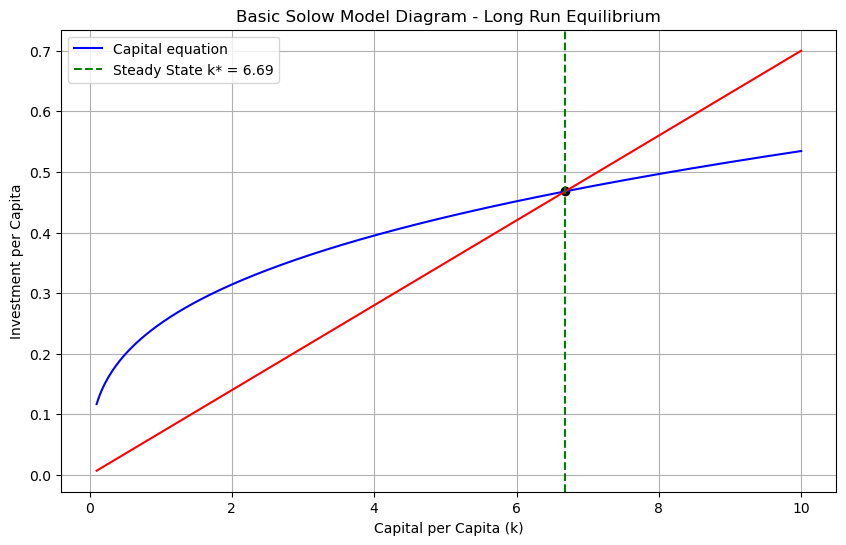

In [17]:
# Parameters
s = 0.25     # Savings rate
alpha = 0.33   # Output elasticity of capital
delta = 0.05  # Depreciation rate
n = 0.02     # Population growth rate

# Range of capital per capita
k = np.linspace(0.1, 10, 400)

# Production function per capita (output per capita)
y = k**alpha

# Actual investment per capita (savings function)
actual_investment = s * y

# Depreciation and population growth curve (break-even investment)
break_even_investment = (delta + n) * k

# Determine the steady state capital per capita analytically
k_star = (s / (delta + n))**(1 / (1 - alpha))

# Plotting the Solow Diagram
plt.figure(figsize=(10, 6))
plt.plot(k, actual_investment, label='Capital equation', color='blue')
plt.plot(k, break_even_investment, color='red')
plt.axvline(x=k_star, color='green', linestyle='--', label=f'Steady State k* = {k_star:.2f}')
plt.scatter(k_star, s * k_star**alpha, color='black')  # Mark the steady state point
plt.title('Basic Solow Model Diagram - Long Run Equilibrium')
plt.xlabel('Capital per Capita (k)')
plt.ylabel('Investment per Capita')
plt.legend()
plt.grid(True)
plt.show()

Thus, the steady state of capital per efficiency unit (i.e., capital per worker adjusted for technology) is lower in the extended model because the economy must continually adapt to a faster pace of technological improvement in addition to natural labor growth and capital depreciation. This scenario reflects the real-world observation where rapid technological changes require continual investment in new capital and skills to keep pace with economic growth, leading to a dynamic where steady states are lower when measured in terms of traditional capital per enhanced labor unit

# Conclusion: Impact of Technological Growth on the Solow Model

The Solow model is a foundational framework in economic growth theory, primarily focused on the roles of capital accumulation and labor growth in driving long-term economic progress. In its basic form, the model demonstrates how a steady state can be reached where the effects of capital accumulation are balanced by the depreciation and natural growth of labor. However, this model lacks components that can explain sustained per capita economic growth once the steady state is reached, as it does not inherently include factors like technological progress.

**Incorporation of Technological Growth** \
The extension of the Solow model to include technological growth introduces a dynamic aspect of continual improvement in production efficiency. This modification is represented by a technological growth rate, $g$, which leads to exponential growth in the technology factor, $A_t$, affecting the production function.

This extension fundamentally alters the trajectory of the economy by not only increasing the output directly but also enhancing the effectiveness of both capital and labor. With technology in the model, even if capital and labor grow at constant rates, the output can continue to increase due to improvements in how these inputs are used.

**Key Observations from the Extended Model**
1. **Higher Output Levels:** Incorporating technological progress leads to higher levels of output compared to the base model, under identical conditions of capital and labor input. This is evident from simulation results where the output trajectory of the extended model consistently surpasses that of the basic model.
2. **Sustained Growth in Per Capita Output:** While the basic Solow model predicts a convergence to a steady state where per capita growth ceases (in the absence of continuing increases in capital or labor), the extended model with technology allows for ongoing growth in per capita output. This aligns more closely with observed economic growth patterns in developed economies, where technological advancements play a crucial role.
3. **Policy Implications:** The extended model underscores the importance of technological innovation and efficiency improvements in policymaking. Investments in technology and related sectors could be crucial for sustained economic growth, particularly in mature economies that have exhausted easy gains from capital accumulation and labor growth.
4. **Complex Dynamics and Sensitivity:** The model’s behavior becomes more sensitive to the parameter $g$, the rate of technological advancement. Small changes in $g$ 
5. **Lower Steady State:** The extended model has a lower steady state value because the economy must continually adapt to a faster pace of technological improvement in addition to natural labor growth and capital depreciation since it is in per effiency units instead of per capita as in the basic model.
